In [1]:
from common.helper_functions import config_gpu

RDKit version: 2018.03.4


In [2]:
config_gpu('0',1)

2019-10-07 15:23:44: Configuring to use GPU 0 with RAM fraction set to grow as needed to as high as 1.


Using TensorFlow backend.


In [3]:
pwd

'/fluency/external'

In [4]:
reviews_train = []
for line in open('aclImdb/movie_data/full_train.txt', 'r', encoding="utf-8"):
    
    reviews_train.append(line.strip())
    
reviews_test = []
for line in open('aclImdb/movie_data/full_test.txt', 'r', encoding="utf-8"):
    
    reviews_test.append(line.strip())

In [5]:
import re

REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
NO_SPACE = ""
SPACE = " "

def preprocess_reviews(reviews):
    
    reviews = [REPLACE_NO_SPACE.sub(NO_SPACE, line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line) for line in reviews]
    
    return reviews

reviews_train_clean = preprocess_reviews(reviews_train)
reviews_test_clean = preprocess_reviews(reviews_test)

In [6]:
len(reviews_test_clean)

25000

In [7]:
target = [1 if i < 12500 else 0 for i in range(25000)]

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=True, lowercase=True, min_df=3, max_df=0.9, max_features=5000)
cv.fit(reviews_train_clean)
X = cv.transform(reviews_train_clean)
#X_test = cv.transform(reviews_test_clean)

# Split Train Test

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_val, y_train, y_val = train_test_split(reviews_train_clean, target, train_size = 0.75)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [11]:
X_train_onehot = cv.transform(X_train)
X_val_onehot = cv.transform(X_val)

# Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [13]:
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train_onehot, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val_onehot))))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.87664
Accuracy for C=0.05: 0.88544
Accuracy for C=0.25: 0.87616
Accuracy for C=0.5: 0.87456
Accuracy for C=1: 0.86688


# Simple NN

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
 
model = Sequential()
 
model.add(Dense(units=500, activation='relu', input_dim=len(cv.get_feature_names())))
model.add(Dense(units=1, activation='sigmoid'))
 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               2500500   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 501       
Total params: 2,501,001
Trainable params: 2,501,001
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.fit(X_train_onehot,
          y_train, 
          epochs=2,
          batch_size=128,
          verbose=1, 
          validation_data=(X_val_onehot, y_val))

Train on 18750 samples, validate on 6250 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/2
18750/18750 [==============================] - 1s 77us/sample - loss: 0.3479 - acc: 0.8537 - val_loss: 0.2991 - val_acc: 0.8766
Epoch 2/2
18750/18750 [==============================] - 1s 58us/sample - loss: 0.1870 - acc: 0.9296 - val_loss: 0.3082 - val_acc: 0.8806


In [16]:
model.evaluate(X_val_onehot, y_val)

6250/6250 [==============================] - 0s 71us/sample - loss: 0.3082 - acc: 0.8806


[0.3081792943954468, 0.88064]

# Convolution NN

In [17]:
word2idx = {word: idx for idx, word in enumerate(cv.get_feature_names())}
tokenize = cv.build_tokenizer()
preprocess = cv.build_preprocessor()
 
def to_sequence(tokenizer, preprocessor, index, text):
    words = tokenizer(preprocessor(text))
    indexes = [index[word] for word in words if word in index]
    return indexes
 
print(to_sequence(tokenize, preprocess, word2idx, "This is an important test!")) #  [2329, 172, 2207, 4408]


[2329, 172, 2207, 4408]


In [18]:
X_train_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in X_train]
X_val_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in X_val]
print(X_train_sequences[0])

[1679, 4140, 730, 50, 3442, 4427, 3055, 326, 1738, 1797, 4718, 389, 4864, 4430, 233, 4047, 1512, 2669, 2429, 2404, 612, 42, 1483, 3058, 4417, 607, 2983, 379, 197, 94, 1656, 2809, 2429, 2217, 2009, 2679, 617, 4948, 493, 4943, 259, 4437, 493, 4718, 197, 4434, 1275, 2009, 172, 44, 3, 419, 4424, 2217, 3933, 4437, 3730, 2331, 1888, 904, 4417, 4437, 2509, 2335, 1471, 2331, 1888, 4858, 4985, 901, 1576, 4417, 2335, 2329, 4747, 2209, 4338, 1674, 3873, 378, 3730, 50, 2339, 3903, 4417, 1674, 2329, 4256, 1082, 2618, 259, 3261, 2331, 2989, 868, 2335, 1733, 4988, 1860, 4867, 94, 1300, 3220, 2135, 2217, 2046, 4773, 4677, 2217, 1607, 4942, 4417, 3910, 2000, 994, 2335, 4060, 380, 216, 2046, 4417, 3910, 607, 4942, 4469, 2046, 4033, 3881, 5, 2675, 4709, 693, 4674, 2046, 1304, 1487, 380, 2963, 3048, 1089, 259, 4985, 607, 3834, 3261, 2565, 1865, 2957, 350, 1741, 1888, 1607, 2125, 2874, 2140, 2335, 2329, 4469, 3009, 1620, 1625, 1695, 2217, 4104, 3325, 395, 172, 1507, 3325, 1741, 2621, 2874, 2329, 1566, 4129

In [19]:
MAX_SEQ_LENGTH = len(max(X_train_sequences, key=len))
print("MAX_SEQ_LENGTH=", MAX_SEQ_LENGTH)

MAX_SEQ_LENGTH= 1437


In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
N_FEATURES = len(cv.get_feature_names())
X_train_sequences = pad_sequences(X_train_sequences, maxlen=MAX_SEQ_LENGTH, value=N_FEATURES)
X_val_sequences = pad_sequences(X_val_sequences, maxlen=MAX_SEQ_LENGTH, value=N_FEATURES)

print(X_train_sequences[0])

[5000 5000 5000 ... 3834 4052 1399]


In [117]:
X_train_sequences_r = pad_sequences(X_train_sequences, padding='post', maxlen=MAX_SEQ_LENGTH, value=N_FEATURES)
X_val_sequences_r = pad_sequences(X_val_sequences, padding='post', maxlen=MAX_SEQ_LENGTH, value=N_FEATURES)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Embedding
 
model = Sequential()
model.add(Embedding(len(cv.get_feature_names()) + 1,
                    64,  # Embedding size
                    input_length=MAX_SEQ_LENGTH))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1437, 64)          320064    
_________________________________________________________________
conv1d (Conv1D)              (None, 1433, 64)          20544     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 286, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 18304)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1171520   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,512,193
Trainable params: 1,512,193
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(X_train_sequences,
          y_train, 
          epochs=2,
          batch_size=128,
          verbose=1, 
          validation_data=(X_val_sequences, y_val))

Train on 18750 samples, validate on 6250 samples
Epoch 1/2
18750/18750 [==============================] - 4s 192us/sample - loss: 0.5484 - acc: 0.6766 - val_loss: 0.3151 - val_acc: 0.8675
Epoch 2/2
18750/18750 [==============================] - 3s 136us/sample - loss: 0.2652 - acc: 0.8952 - val_loss: 0.3022 - val_acc: 0.8738


In [23]:
model.evaluate(X_val_sequences, y_val)

6250/6250 [==============================] - 0s 58us/sample - loss: 0.3022 - acc: 0.8738


[0.3021879968214035, 0.87376]

# LSTM

In [139]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
 
model = Sequential()
model.add(Embedding(len(cv.get_feature_names()) + 1,
                    64,  # Embedding size
                    input_length=MAX_SEQ_LENGTH))
model.add(LSTM(64))
model.add(Dense(units=1, activation='sigmoid'))
 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1437, 64)          320064    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 353,153
Trainable params: 353,153
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.fit(X_train_sequences,
          y_train, 
          epochs=2,
          batch_size=128,
          verbose=1, 
          validation_data=(X_val_sequences, y_val))

In [26]:
model.evaluate(X_val_sequences, y_val)

6250/6250 [==============================] - 116s 19ms/sample - loss: 0.3069 - acc: 0.8765


[0.30690554965019223, 0.87648]

# Transformer One-Shot

In [314]:
from common.layer.attention import MultiHeadSelfAttention
from common.layer.normalization import LayerNormalization
from tensorflow.keras.layers import Input, Lambda, Add, Activation, GlobalAveragePooling1D
from common.layer.position import AddPositionalEncoding


In [28]:
from tensorflow.keras.optimizers import Adam

In [29]:
from tensorflow.keras import backend as K

In [30]:
from tensorflow.keras.models import Model

In [31]:
MAX_SEQ_LENGTH

1437

In [320]:
K.clear_session()
sequence_input = Input(shape=(MAX_SEQ_LENGTH,))

embed = Embedding(len(cv.get_feature_names()) + 1,
                  64,  # Embedding size
                  input_length=MAX_SEQ_LENGTH)(sequence_input)

#embed = Lambda(lambda x: x*10, name='embed_scaled')(embed)
#embed = AddPositionalEncoding()(embed)

x = embed

for i in range(1):
    y = MultiHeadSelfAttention(num_heads=4,
                           use_masking=False,
                           dropout=0,
                           name='self_attention%d'%i)(x)

    y = Dense(32, activation='relu')(y)
    y = Dense(64)(y)
    
    x = Add()([x,y])
#    x = LayerNormalization()(x)



x = GlobalAveragePooling1D()(x)


output = Dense(units=1, activation='sigmoid')(x)

model = Model(sequence_input, output)

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1437)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1437, 64)     320064      input_1[0][0]                    
__________________________________________________________________________________________________
self_attention0 (MultiHeadSelfA (None, 1437, 64)     16384       embedding[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 1437, 32)     2080        self_attention0[0][0]            
__________________________________________________________________________________________________
dense_1 (D

In [321]:
model.fit(X_train_sequences,
          y_train, 
          epochs=1,
          batch_size=16,
          verbose=1, 
          validation_data=(X_val_sequences, y_val))

Train on 18750 samples, validate on 6250 samples
18750/18750 [==============================] - 74s 4ms/sample - loss: 0.4772 - acc: 0.7418 - val_loss: 0.3108 - val_acc: 0.8667


In [322]:
model.evaluate(X_val_sequences, y_val)

6250/6250 [==============================] - 8s 1ms/sample - loss: 0.3108 - acc: 0.8667


[0.31082940051078795, 0.86672]

# Add Postional Encoding

In [329]:
K.clear_session()
sequence_input = Input(shape=(MAX_SEQ_LENGTH,))

embed = Embedding(len(cv.get_feature_names()) + 1,
                  64,  # Embedding size
                  input_length=MAX_SEQ_LENGTH)(sequence_input)

#embed = Lambda(lambda x: x*1000, name='embed_scaled')(embed)
embed = AddPositionalEncoding()(embed)

x = embed

for i in range(3):
    y = MultiHeadSelfAttention(num_heads=4,
                           use_masking=False,
                           dropout=0,
                           name='self_attention%d'%i)(x)

    y = Dense(32, activation='relu')(y)
    y = Dense(64)(y)
    #y = Conv1D(kernel_size=1, filters=32)(y)
    #y = Activation('relu')(y)
    #y = Conv1D(kernel_size=1, filters=64)(y)
    
    x = Add()([x,y])
    x = LayerNormalization()(x)

x = GlobalAveragePooling1D()(x)

output = Dense(units=1, activation='sigmoid')(x)


model = Model(sequence_input, output)

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1437)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1437, 64)     320064      input_1[0][0]                    
__________________________________________________________________________________________________
add_positional_encoding (AddPos (None, 1437, 64)     0           embedding[0][0]                  
__________________________________________________________________________________________________
self_attention0 (MultiHeadSelfA (None, 1437, 64)     16384       add_positional_encoding[0][0]    
__________________________________________________________________________________________________
dense (Den

In [332]:
model.fit(X_train_sequences,
          y_train, 
          epochs=2,
          batch_size=16,
          verbose=1, 
          validation_data=(X_val_sequences, y_val))

Train on 18750 samples, validate on 6250 samples
Epoch 1/2
18750/18750 [==============================] - 217s 12ms/sample - loss: 0.3211 - acc: 0.8592 - val_loss: 0.3015 - val_acc: 0.8717
Epoch 2/2
18750/18750 [==============================] - 217s 12ms/sample - loss: 0.2391 - acc: 0.9055 - val_loss: 0.3256 - val_acc: 0.8645


In [333]:
model.evaluate(X_val_sequences, y_val)

6250/6250 [==============================] - 24s 4ms/sample - loss: 0.3256 - acc: 0.8645


[0.32557876320123674, 0.86448]

# Use LR FINDER

In [176]:
from common.optimizer.lr_finder import LRFinder

In [293]:
lr_finder = LRFinder(min_lr=1e-2,
                     max_lr=0.2,
                     linear=True,
                     steps_per_epoch=np.ceil(18750/16),
                     epochs=1)


In [294]:
model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'],
              )

In [295]:
model.fit(X_train_sequences,
          y_train, 
          epochs=1,
          batch_size=16,
          verbose=1, 
#          validation_data=(X_val_sequences, y_val),
          callbacks=[lr_finder])

18750/18750 [==============================] - 67s 4ms/sample - loss: 2.3338 - acc: 0.5061


(0.1, 0.3)

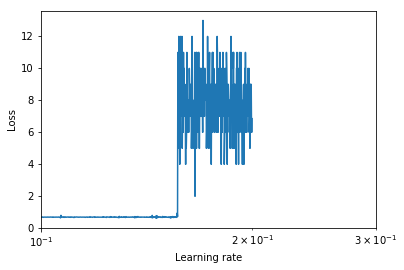

In [296]:
lr_finder.plot_loss()
xlim(10e-2,0.3)

In [47]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['flatten']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [299]:
model.layers

In [300]:
analysis_model = Model(model.inputs,
                       model.layers[-1].output)

In [309]:
output = analysis_model.predict(X_train_sequences)

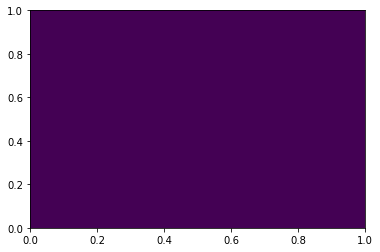

In [302]:
pcolor(analysis_model.predict(X_train_sequences[[0]])[0])

In [50]:
analysis_model = Model(model.inputs,
                       model.layers[2].output)

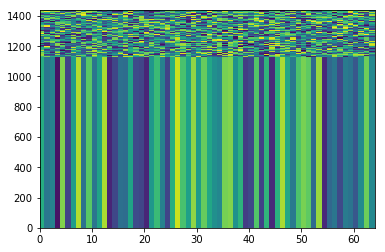

In [51]:
pcolor(analysis_model.predict(X_train_sequences[[0]])[0])

# Visualize The positional encoding.

In [171]:
import tensorflow as tf

In [172]:
with tf.Session() as sess:

    foo = model.layers[2].signal.eval()

AttributeError: 'Lambda' object has no attribute 'signal'

In [ ]:
%pylab inline

In [148]:
debug_model = Model(inputs=model.input,
                    outputs=[model.layers[2].output])

In [149]:
print(np.min(debug_model.predict(X_val_sequences[0:1,:])))
print(np.max(debug_model.predict(X_val_sequences[0:1,:])))

-628.59705
638.41345


In [150]:
np.max(foo.squeeze())

1.0

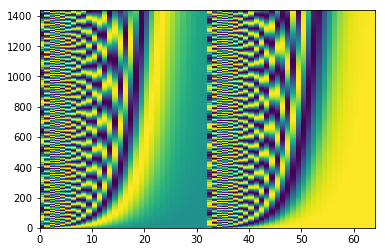

In [135]:
pcolor(foo.squeeze())